# Advance Lane Detection

# Step1 : Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
#%matplotlib qt

##### Define Placeholder(s) & Load Calibration Images 

In [2]:
# Prepare object points required for calibration, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# Samples Size: 9x6
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

#Print Object Point
print ("Object Points As Follows",objp)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calib*.jpg')

Object Points As Follows [[ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 2.  0.  0.]
 [ 3.  0.  0.]
 [ 4.  0.  0.]
 [ 5.  0.  0.]
 [ 6.  0.  0.]
 [ 7.  0.  0.]
 [ 8.  0.  0.]
 [ 0.  1.  0.]
 [ 1.  1.  0.]
 [ 2.  1.  0.]
 [ 3.  1.  0.]
 [ 4.  1.  0.]
 [ 5.  1.  0.]
 [ 6.  1.  0.]
 [ 7.  1.  0.]
 [ 8.  1.  0.]
 [ 0.  2.  0.]
 [ 1.  2.  0.]
 [ 2.  2.  0.]
 [ 3.  2.  0.]
 [ 4.  2.  0.]
 [ 5.  2.  0.]
 [ 6.  2.  0.]
 [ 7.  2.  0.]
 [ 8.  2.  0.]
 [ 0.  3.  0.]
 [ 1.  3.  0.]
 [ 2.  3.  0.]
 [ 3.  3.  0.]
 [ 4.  3.  0.]
 [ 5.  3.  0.]
 [ 6.  3.  0.]
 [ 7.  3.  0.]
 [ 8.  3.  0.]
 [ 0.  4.  0.]
 [ 1.  4.  0.]
 [ 2.  4.  0.]
 [ 3.  4.  0.]
 [ 4.  4.  0.]
 [ 5.  4.  0.]
 [ 6.  4.  0.]
 [ 7.  4.  0.]
 [ 8.  4.  0.]
 [ 0.  5.  0.]
 [ 1.  5.  0.]
 [ 2.  5.  0.]
 [ 3.  5.  0.]
 [ 4.  5.  0.]
 [ 5.  5.  0.]
 [ 6.  5.  0.]
 [ 7.  5.  0.]
 [ 8.  5.  0.]]


##### Step through the images and search for chessboard corners.

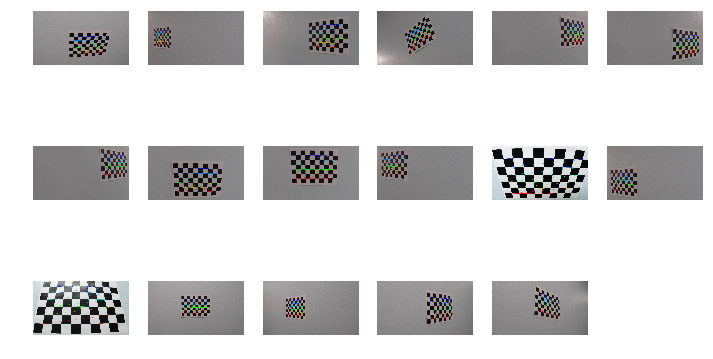

In [3]:
# Step through the list and search for chessboard corners
i=0
plt.figure(figsize=(12,12))
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #BGR2GRAY as imread is opencv and not matplot

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        i+=1
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.subplot(5, 6, i)
        plt.axis('off')
        plt.imshow(img)

        
## Sample Code for seperate modal windows
#cv2.imshow('img', img)
#cv2.waitKey(500)
#cv2.destroyAllWindows()

# Step 2 - Write Helper Functions
##### Calibration,Undistort, Gradient (Sobel, Magnitude, Directional, S Channel), Perspective Change(Warp), Lane Finding, Polynomail Fit & Visualizations

In [58]:
# CALIBRATE GENERTE CAMERA SETTINGS, PERSIST THEM TO HELP UNDISTORT IMAGES
def calibrate():
    print ("********* CALIBRATION STARTING ...")
    # Retrieve Image Size to be used for deriving coefficients
    img = cv2.imread('camera_cal/calibration1.jpg')
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points & retrieve coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open("camera_cal/calibration_results/calibration_dist.p", "wb" ))
    
    #Test Calibration on one sample image
    print ("Testing One Sample Image ensuring it is working fine... ")
    udt = cv2.undistort(img, mtx, dist, None, mtx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img, cmap="gray")
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(udt)
    ax2.set_title('Undistorted Image', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    print ("********* CALIBRATION COMPLETED AND COEFFICIENTS STORED **********")

# UNDISTORT MULTIPLE IMAGES GIVEN SOURCE AND DESTINATION LOCATIONS TO READ AND WRITE FROM
def undistortAll(source_location, target_location, mtx, dist):
    print ("********* UNDISTORT IMAGES STARTING ...")   
    # Step through the list of images to be calibrated, calibrate the same and store at camera_cal/calibrated
    test_images = glob.glob(source_location)
    count = 0
    
    for idx, fname in enumerate(test_images):
        img = cv2.imread(fname)
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        fn = target_location + fname[12:]
        #print(idx, fn)
        x = cv2.imwrite(fn,dst)
        count = count + 1 if x else None
        #plt.imshow(dst)

    print ("********* UNDISTORT IMAGES COMPLETED WITH COUNT - ", count, "  ********")

# UNDISTORT ONE IMAGE AT A TIME, RECEIVES INPUT AS IMAGE AND RETURN UNDISTORTED IMAGE
def undistort(image):
        cam_meta = pickle.load(open("camera_cal/calibration_results/calibration_dist.p", "rb"))
        mtx, dist = cam_meta['mtx'], cam_meta['dist']
        undst = cv2.undistort(image, mtx, dist, None, mtx)
        return undst

# APPLY SOBEL GRADIENT AND THERSHOLD: INPUT - IMAGE, ORIENTATION, KERNEL SIZE, THRESHOLD, OUTPUT - OPTIMIZED IMAGE
def abs_sobel_thresh(image_gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    if orient == 'x':
        sobel=cv2.Sobel(image_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel=cv2.Sobel(image_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    #Absolute of Sobel
    abs_sobel= np.absolute(sobel)
    
    #Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create placeholder
    grad_binary = np.zeros_like(scaled_sobel)
    
    # Apply threshold
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

# APPLY GRADIENT MAGNITUDE TO SOBEL GRADIENT AND THERSHOLD: INPUT - IMAGE, KERNEL SIZE, THRESHOLD 
# OUTPUT - OPTIMIZED IMAGE
def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    sobelx=cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely=cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    #Magnitude of Gradient
    gradmag= np.sqrt(sobelx**2 + sobely**2)
    
    #Rescale back to 8 bit integer
    scaled_factor = np.max(gradmag)/255
    gradmag = (gradmag/scaled_factor).astype(np.uint8)
    
    # Create placeholder
    mag_binary = np.zeros_like(gradmag)
    
    # Apply threshold
    mag_binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    
    return mag_binary

# APPLY DIRECTIONAL GRADIENT TO SOBEL GRADIENT AND THERSHOLD: INPUT - IMAGE, KERNEL SIZE, THRESHOLD 
# OUTPUT - OPTIMIZED IMAGE
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate directional gradient
    sobelx=cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely=cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    #Absolute of Gradient
    absgraddir= np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    #Rescale back to 8 bit integer
    scaled_factor = np.max(absgraddir)/255
    scaled_absgraddir = (absgraddir/scaled_factor).astype(np.uint8)
    
    # Create placeholder
    dir_binary = np.zeros_like(scaled_absgraddir)
    
    # Apply threshold
    dir_binary[(scaled_absgraddir >= thresh[0]) & (scaled_absgraddir <= thresh[1])] = 1

    return dir_binary

# APPLY PERSPECTIVE ADJUSTMENT: INPUT - IMAGE, SOURCE COORDINATES, DESTINATION COORDINATES 
# OUTPUT - INVERSE COEFFICENTS & OPTIMIZED IMAGE
def warp (image, src, dst):
        M = cv2.getPerspectiveTransform(src, dst)
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        Minv = cv2.getPerspectiveTransform(dst, src)
        warped_img = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
        return Minv, warped_img

# APPLY COLOR GRADIENT TO S CHANNEL AND THERSHOLD: INPUT - IMAGE, THRESHOLD 
# OUTPUT - OPTIMIZED IMAGE
def color_threshold(img, thresh):
    # 1) Convert to HLS color space
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s_channel = hls_img[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# FIND LANE LEFT(X.Y) AND RIGHT(X,Y) COORDINATES - INPUT: WARPED & GRADIENT OPTIMIZED IMAGE
# OUTPUT: LEFT(X.Y) AND RIGHT(X,Y)
def lane_finding(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    return leftx, lefty, rightx, righty

# HELPER FUNCTION TO APPLY POLYFIT, INPUT: WARPED IMAGE, LEFT(X,Y), RIGHT(X,Y)
# OUTPUT: PLOT AREA, LEFT BLENDED AND RIGHT BLENDED
def poly_fit(binary_warped, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return ploty, left_fitx, right_fitx

# HELPER FUNCTION TO FIND CURVATURE - INPUT: PLOT AREA, LEFT(X,Y), RIGHT(X,Y)
# OUTPUT: LEFT CURVED AND RIGHT CURVED
def curvature(ploty, leftx, lefty, rightx, righty):
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

# HELPER FUNCTION TO DERIVE OFFSET TO CENTER FOR DIAPLYING TEXT
def offset(result, pts_left, pts_right):
    xm_per_pix = 3.7 / 700
    lane_difference = pts_right[0, pts_right[0,:,1].argmax(), 0] - pts_left[0, pts_left[0,:,1].argmax(), 0]
    offset_center = (lane_difference - result.shape[1]/2) * xm_per_pix
    return offset_center

# HELPER FUNCTION TO DISPLAY LANE LINES, LANE PLOT AREA AND INFORMATIONAL TEXT 
def visualization(warped, ploty, left_fitx, right_fitx, Minv, undist, left_curverad, right_curverad,drawLane=True,drawZone=True,drawText=True):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    result = warped
    
    if drawLane:        
        #Draw Lane Boundaries
        margin=40
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))

        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane edges onto the warped blank image as blue
        cv2.fillPoly(color_warp, np.int_([left_line_pts]), (0,0,255))
        cv2.fillPoly(color_warp, np.int_([right_line_pts]), (0,0,255))
        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp1 = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
        # Combine the result with the original image
        result1 = cv2.addWeighted(undist, 1, newwarp1, 1, 0)

    if drawZone:
        # Draw the lane area onto the warped blank image as green
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
        # Combine the result with the original image
        if drawLane:
            result = cv2.addWeighted(result1, 1, newwarp, 0.4, 0)
        else:
            result = cv2.addWeighted(color_warp, 1, newwarp, 0.4, 0)

    if drawText:
        # Write the results on images using OpenCV 
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_size = 1.5
        color = (255,255,255)
        text = "Left Curvature: {} m".format(round(left_curverad, 3))
        cv2.putText(result, text, (400, 50), font, font_size, color, 2)
        text = "Right Curvature: {} m".format(round(right_curverad, 3))
        cv2.putText(result, text, (400, 100), font, font_size, color, 2)
        center_offset = offset(result, pts_left, pts_right)
        text = "Vehicle is {}m left of center".format(round(center_offset, 3))
        cv2.putText(result, text,(400,150), font, font_size, color, 2)

    return result

# STEP 3 - DEFINE PIPELINE 

1. APPLY GRADIENT THRESHOLD USING SOBEL, MAGNITUDE, DIRECTIONAL  -- [ COMBINE ALL ]
2. APPLY COLOR SPACE TO S CHANNEL, COMBINE GRADIENT AND COLOR CHANNEL OUTPUT
3. PERSPECTIVE TRANSFORM 
4. LANE DETECTION
5. POLYFIT LANE LINES & LANE PLOT AREA
6. FIND CURVATURES
7. VISUALIZE RESULTS OVER ORIGINAL IMAGE

In [59]:
#DEFINE PIPLEINE AS ARTICULATED ABOVE

def pipeline(image):
        
    #Call Un-Distort if requested
    image = undistort(image)
    
    #Generate Grasyscale of Images
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #plt.imshow(image_gray, cmap='gray')
        
    #Sabel Derivative Gradient on X Orientation
    gradx = abs_sobel_thresh(image_gray, orient='x', sobel_kernel=11, thresh=(30, 150))
    #plt.imshow(gradx, cmap='gray')
    
    #Sabel Derivative Gradient on Y Orientation
    grady = abs_sobel_thresh(image_gray, orient='y', sobel_kernel=11, thresh=(30, 200))
    #plt.imshow(grady, cmap='gray')
    
    #Magnitude of Gradient
    gradmag = mag_thresh(image_gray, sobel_kernel=11, thresh=(30, 150))
    #plt.imshow(gradmag, cmap='gray')
    
    #Direction of Gradient
    graddir = dir_threshold(image_gray, sobel_kernel=21, thresh=(100, 180))
    #plt.imshow(graddir, cmap='gray')
    
    #Combine Various Gradient(s)
    combined_gradient = np.zeros_like(graddir)
    combined_gradient[((gradx == 1) & (grady == 1)) | ((gradmag == 1) & (graddir == 1))] = 1
    #plt.imshow(combined_gradient, cmap='gray')
    
    #Color Gradient for S Channel
    grad_s = color_threshold(image, thresh=(80, 255))
        
    #Combine Gradient Binary with Color Binary
    combined = np.zeros_like(grad_s)
    combined[(grad_s == 1) | (combined_gradient == 1)] = 1
    #plt.imshow(combined, cmap='gray')
    
    #Apply Perspectice Transform (DON'T HARDCODE VALUES, APPARENTLY IT FAIL BADLY)
    img_size = (image.shape[1], image.shape[0])
    src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

    dst = np.float32([[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    Minv, warp_img = warp(combined, src, dst)
        
    #plt.imshow(combined, cmap='gray')
    
    #Lane Finding (Return Coordinates Found)
    leftx, lefty, rightx, righty = lane_finding(warp_img)
    
    #Ployfit Based on the coordinates from the Lane Finding Routine
    ploty, left_fitx, right_fitx = poly_fit(warp_img, leftx, lefty, rightx, righty)
    
    #Find Curves based on the polyfit & lane finding routines
    left_curverad, right_curverad = curvature(ploty, leftx, lefty, rightx, righty)
    
    #Visualize Lane Lines, Plot Area and Informational Text 
    image_with_overlay = visualization(warp_img, ploty, left_fitx, right_fitx, Minv, image, left_curverad, right_curverad)
        
    return image_with_overlay

### As a good programmer, let's some basic tests before running all samples...  

********* CALIBRATION STARTING ...
Testing One Sample Image ensuring it is working fine... 
********* CALIBRATION COMPLETED AND COEFFICIENTS STORED **********


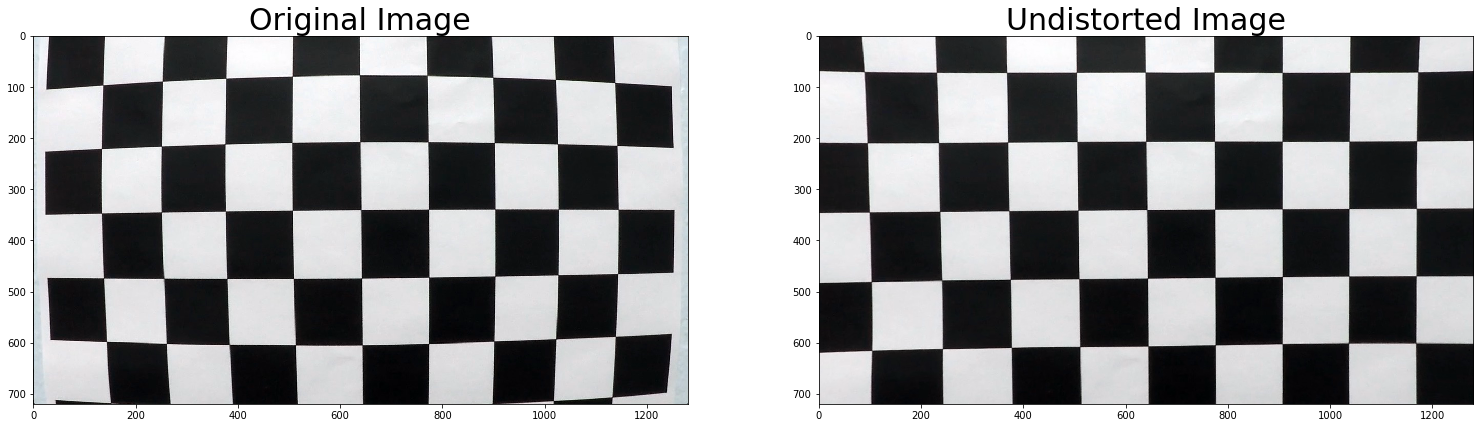

In [64]:
# Test & Run Calibrate
calibrate()

***** As a good programmer, let's some basic tests before running all samples... *****



/Users/anmehra/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:144: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


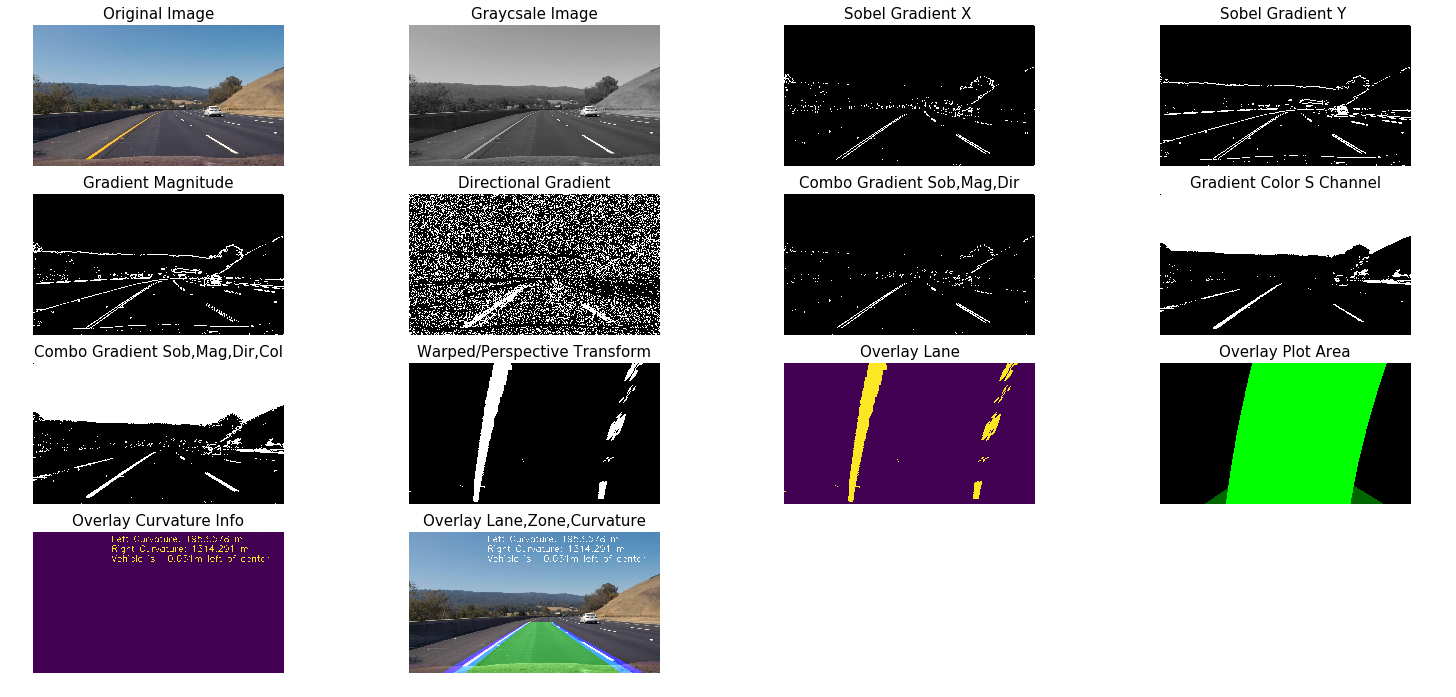

In [65]:
# Test rest of the helper functions with their outputs
import matplotlib.image as mpimg

print("***** As a good programmer, let's some basic tests before running all samples... *****")
print()
    
# Retrieve Test Image
image = mpimg.imread('test_images/test3.jpg')
    
f, axes = plt.subplots(4, 4, figsize=(20,10))
    
axes[0,0].imshow(image)
axes[0,0].set_title('Original Image', fontsize=15)
axes[0,0].axis('off')
    
#Generate Grasyscale of Images
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
axes[0,1].imshow(image_gray, cmap='gray')
axes[0,1].set_title('Graycsale Image', fontsize=15)
axes[0,1].axis('off')

#Generate Grasyscale of Images
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
axes[0,1].imshow(image_gray, cmap='gray')
axes[0,1].set_title('Graycsale Image', fontsize=15)
axes[0,1].axis('off')
    
#Sobel Derivative Gradient on X Orientation
gradx = abs_sobel_thresh(image_gray, orient='x', sobel_kernel=11, thresh=(30, 150))
axes[0,2].imshow(gradx, cmap='gray')
axes[0,2].set_title('Sobel Gradient X ', fontsize=15)
axes[0,2].axis('off')

#Sobel Derivative Gradient on Y Orientation
grady = abs_sobel_thresh(image_gray, orient='y', sobel_kernel=11, thresh=(30, 200))
axes[0,3].imshow(grady, cmap='gray')
axes[0,3].set_title('Sobel Gradient Y ', fontsize=15)
axes[0,3].axis('off')

#Magnitude of Gradient
gradmag = mag_thresh(image_gray, sobel_kernel=11, thresh=(30, 150))
axes[1,0].imshow(gradmag, cmap='gray')
axes[1,0].set_title('Gradient Magnitude', fontsize=15)
axes[1,0].axis('off')

#Direction of Gradient
graddir = dir_threshold(image_gray, sobel_kernel=21, thresh=(100, 180))
axes[1,1].imshow(graddir, cmap='gray')
axes[1,1].set_title('Directional Gradient', fontsize=15)
axes[1,1].axis('off')

#Combine Various Gradient(s)
combined_gradient = np.zeros_like(graddir)
combined_gradient[((gradx == 1) & (grady == 1)) | ((gradmag == 1) & (graddir == 1))] = 1
axes[1,2].imshow(combined_gradient, cmap='gray')
axes[1,2].set_title('Combo Gradient Sob,Mag,Dir', fontsize=15)
axes[1,2].axis('off')
    
#Color Gradient for S Channel
grad_s = color_threshold(image, thresh=(80, 255))
axes[1,3].imshow(grad_s, cmap='gray')
axes[1,3].set_title('Gradient Color S Channel', fontsize=15)
axes[1,3].axis('off')

#Combine Gradient Binary with Color Binary
combined = np.zeros_like(grad_s)
combined[(grad_s == 1) | (combined_gradient == 1)] = 1
axes[2,0].imshow(combined, cmap='gray')
axes[2,0].set_title('Combo Gradient Sob,Mag,Dir,Col', fontsize=15)
axes[2,0].axis('off')
    
#Apply Perspectice Transform (DON'T HARDCODE VALUES, APPARENTLY IT FAIL BADLY)
img_size = (image.shape[1], image.shape[0])
src = np.float32([[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
[((img_size[0] / 6) - 10), img_size[1]],
[(img_size[0] * 5 / 6) + 60, img_size[1]],
[(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])

dst = np.float32([[(img_size[0] / 4), 0],
[(img_size[0] / 4), img_size[1]],
[(img_size[0] * 3 / 4), img_size[1]],
[(img_size[0] * 3 / 4), 0]])

Minv, warp_img = warp(combined, src, dst)
      
axes[2,1].imshow(warp_img, cmap='gray')
axes[2,1].set_title('Warped/Perspective Transform', fontsize=15)
axes[2,1].axis('off')
    
#Lane Finding (Return Coordinates Found)
leftx, lefty, rightx, righty = lane_finding(warp_img)
#Ployfit Based on the coordinates from the Lane Finding Routine
ploty, left_fitx, right_fitx = poly_fit(warp_img, leftx, lefty, rightx, righty)
#Find Curves based on the polyfit & lane finding routines
left_curverad, right_curverad = curvature(ploty, leftx, lefty, rightx, righty)

#Visualize Lane Lines
image_with_overlay = visualization(warp_img, ploty, left_fitx, right_fitx, Minv, image, left_curverad, right_curverad,True,False,False)
axes[2,2].imshow(image_with_overlay)
axes[2,2].set_title('Overlay Lane', fontsize=15)
axes[2,2].axis('off')

#Visualize Plot Area 
image_with_overlay = visualization(warp_img, ploty, left_fitx, right_fitx, Minv, image, left_curverad, right_curverad,False,True,False)
axes[2,3].imshow(image_with_overlay)
axes[2,3].set_title('Overlay Plot Area', fontsize=15)
axes[2,3].axis('off')

#Visualize Informational Text
image_with_overlay = visualization(warp_img, ploty, left_fitx, right_fitx, Minv, image, left_curverad, right_curverad,False,False,True)
axes[3,0].imshow(image_with_overlay)
axes[3,0].set_title('Overlay Curvature Info', fontsize=15)
axes[3,0].axis('off')

#Visualize Lane Lines, Plot Area and Informational Text
image_with_overlay = visualization(warp_img, ploty, left_fitx, right_fitx, Minv, image, left_curverad, right_curverad,True,True,True)
axes[3,1].imshow(image_with_overlay)
axes[3,1].set_title('Overlay Lane,Zone,Curvature', fontsize=15)
axes[3,1].axis('off')

#Clear axis
axes[3,2].axis('off')
axes[3,3].axis('off')

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# STEP 4 - MOMENT OF TRUTH, TEST THE PIPELINE...

/Users/anmehra/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:144: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


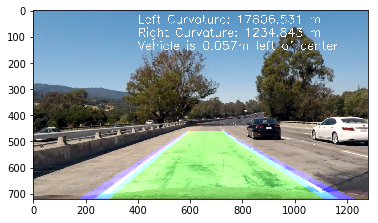

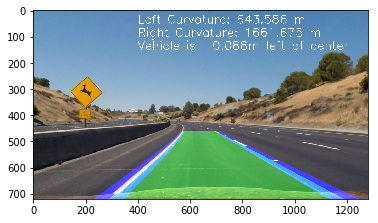

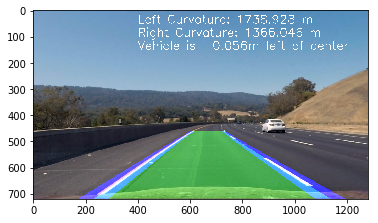

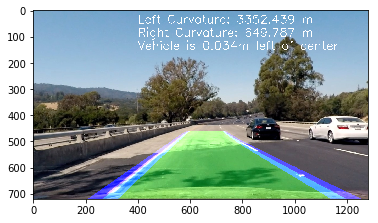

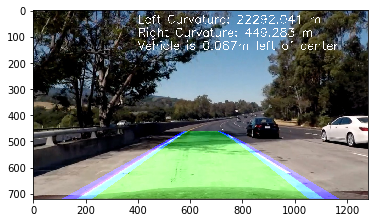

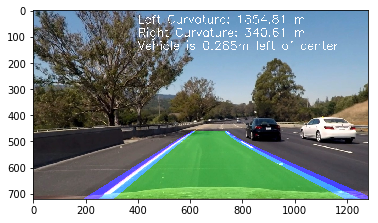

In [68]:
#Call Pipeline for all Test Images
images = glob.glob('test_images/test*.jpg')

for fname in images:
    img = mpimg.imread(fname)
    image_with_overlay = pipeline(img)
    plt.imshow(image_with_overlay, cmap='gray')
    plt.figure()

In [69]:
from moviepy.editor import VideoFileClip

#Test the pipeline on the PROJECT VIDEO sample
video_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(pipeline)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:11<00:00,  3.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 6min 58s, sys: 1min 6s, total: 8min 5s
Wall time: 6min 12s


In [70]:
#Test the pipeline on the Challenge VIDEO sample
video_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
video_clip = clip1.fl_image(pipeline)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [02:17<00:00,  3.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 2min 35s, sys: 24.8 s, total: 3min
Wall time: 2min 17s


In [71]:
#Test the pipeline on the Hard Challenge VIDEO sample
video_output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
video_clip = clip1.fl_image(pipeline)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████▉| 1199/1200 [06:13<00:00,  3.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 6min 55s, sys: 1min 4s, total: 8min
Wall time: 6min 14s
